<div style="background-color:#2BAEFF; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌<b> Approach 💡</b><br>
    Soft voting classifier with K Fold CV and optuna based hyperparameter optimization with feature importances<br>
    </div>

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
    Importing modules.
    </div>

In [1]:
import pandas as pd
import numpy as np
import optuna
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_predict
import seaborn as sns
import matplotlib.pyplot as plt


<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
   Reading the train and test dataframes
    </div>

In [2]:
train_df = pd.read_csv('/kaggle/input/playground-series-s3e24/train.csv')
test_df = pd.read_csv('/kaggle/input/playground-series-s3e24/test.csv')

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
    Inspecting the columns of the dataframe
    </div>

In [3]:
train_df.columns

Index(['id', 'age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)',
       'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic',
       'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride',
       'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST',
       'ALT', 'Gtp', 'dental caries', 'smoking'],
      dtype='object')

In [4]:
test_df.columns

Index(['id', 'age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)',
       'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic',
       'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride',
       'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST',
       'ALT', 'Gtp', 'dental caries'],
      dtype='object')

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
    Defining features and target variable
    </div>

In [5]:
features = train_df.columns.drop(['id', 'smoking'])
target = 'smoking'

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
    Splitting the data into features and target
    </div>

In [6]:
X = train_df[features]
y = train_df[target]

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Visualizing the distribution of the target variable    </div>

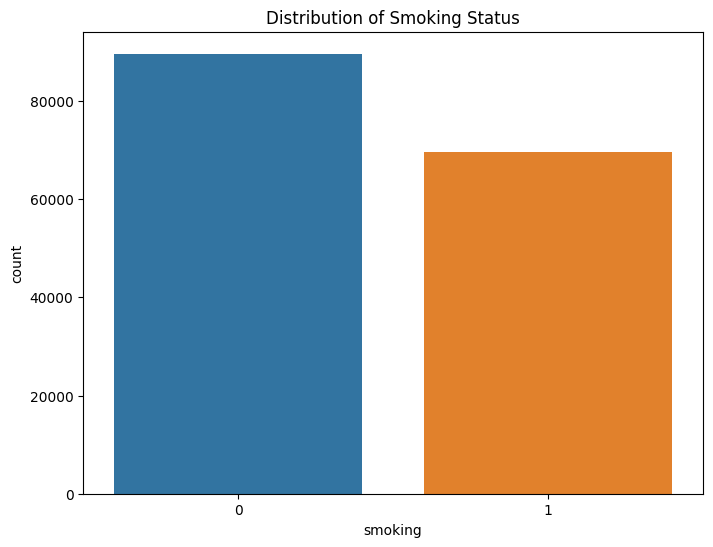

In [7]:
plt.figure(figsize=(8, 6))
sns.countplot(x='smoking', data=train_df)
plt.title('Distribution of Smoking Status')
plt.show()


<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
    Visualizing boxplot of numerical features
    </div>

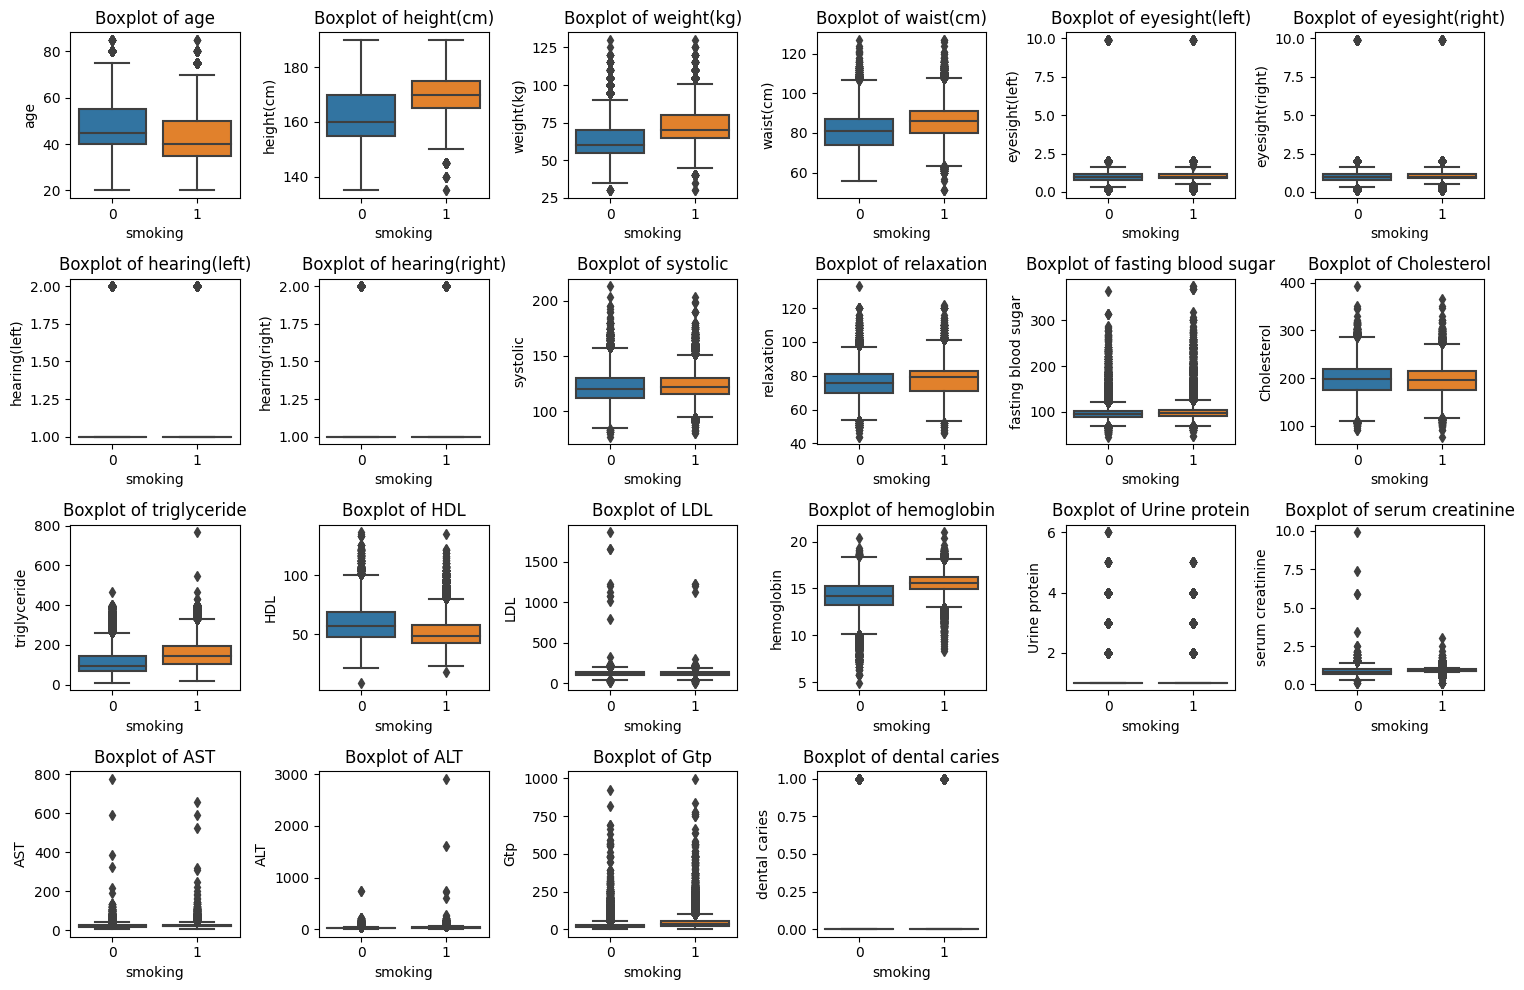

In [8]:
plt.figure(figsize=(15, 10))
for i, feature in enumerate(features):
    plt.subplot(4, 6, i + 1)
    sns.boxplot(x='smoking', y=feature, data=train_df)
    plt.title(f'Boxplot of {feature}')
plt.tight_layout()
plt.show()


<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
    Visualizing histogram of numerical features
    </div>

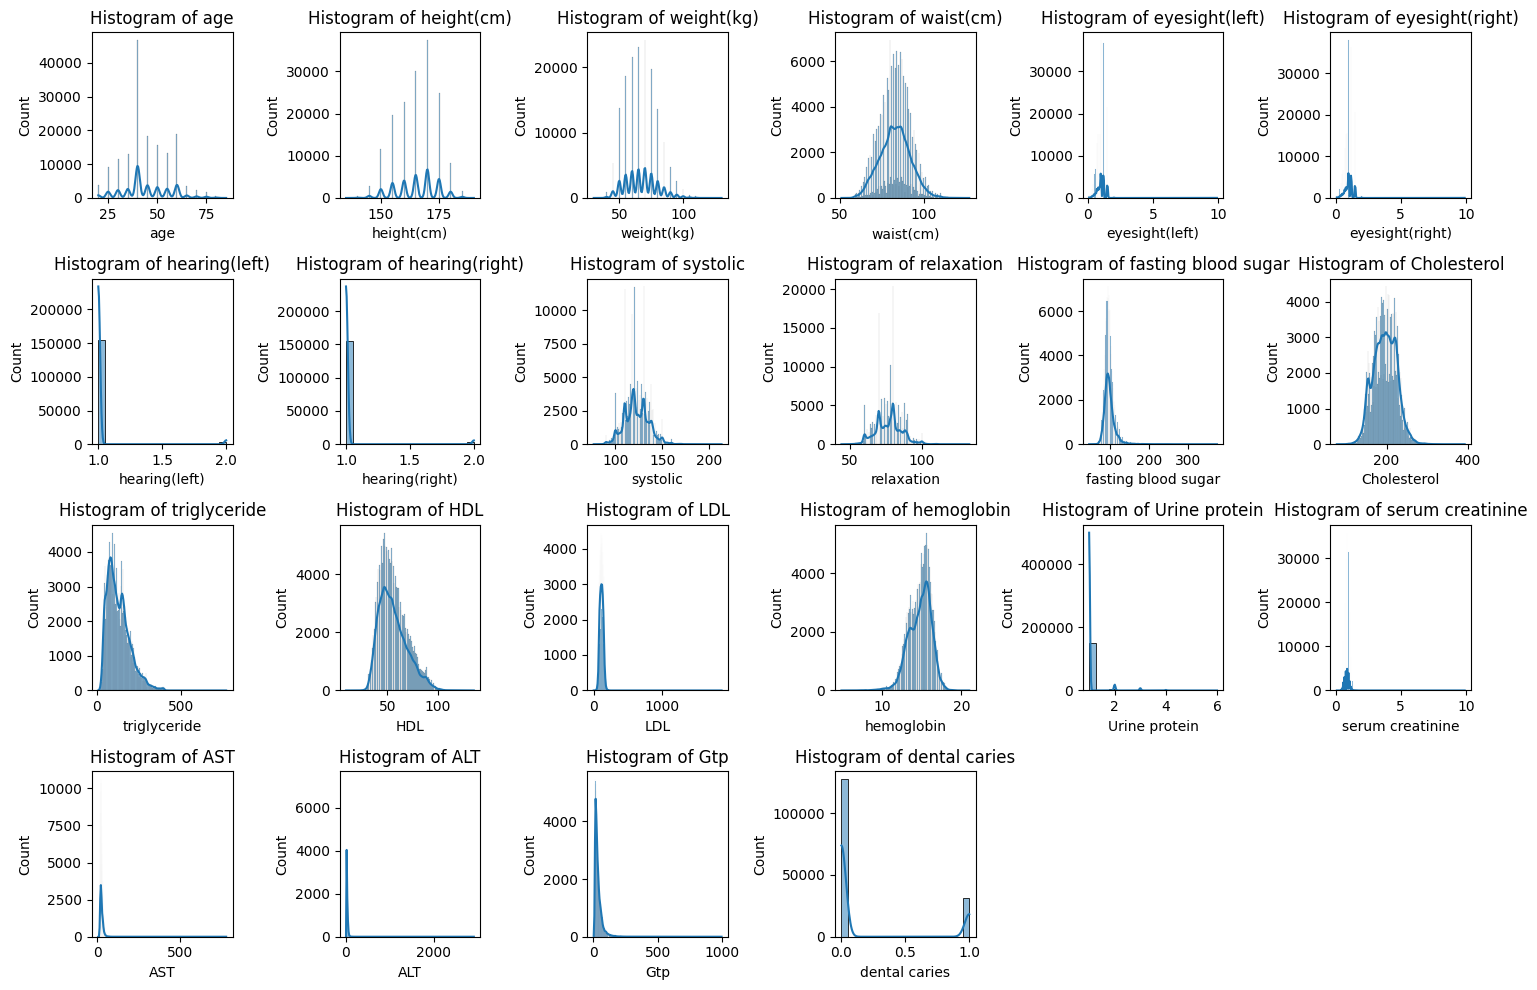

In [9]:
plt.figure(figsize=(15, 10))
for i, feature in enumerate(features):
    plt.subplot(4, 6, i + 1)
    sns.histplot(x=feature, data=train_df, kde=True)
    plt.title(f'Histogram of {feature}')
plt.tight_layout()
plt.show()

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
    Defining soft voting classifier
    </div>

In [10]:
def soft_voting_classifier(trial):
    # Defining hyperparameters for individual classifiers
    rf_params = {
        'n_estimators': trial.suggest_int('n_estimators_rf', 50, 200),
        'max_depth': trial.suggest_int('max_depth_rf', 5, 20),
        'min_samples_split': trial.suggest_int('min_samples_split_rf', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf_rf', 1, 5),
        'random_state': 42
    }

    gb_params = {
        'n_estimators': trial.suggest_int('n_estimators_gb', 50, 200),
        'max_depth': trial.suggest_int('max_depth_gb', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate_gb', 0.01, 0.1),
        'subsample': trial.suggest_float('subsample_gb', 0.5, 1.0),
        'random_state': 42
    }

    lr_params = {
        'C': trial.suggest_float('C_lr', 0.1, 10.0),
        'penalty': trial.suggest_categorical('penalty_lr', ['l2']),
        'random_state': 42
    }

    # Initializing classifiers with optimal hyperparameters
    rf = RandomForestClassifier(**rf_params)
    gb = GradientBoostingClassifier(**gb_params)
    lr = LogisticRegression(**lr_params)

    # Creating soft voting classifier
    classifier = VotingClassifier(estimators=[('rf', rf), ('gb', gb), ('lr', lr)], voting='soft')

    return classifier


<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
    Defining objective function for optuna
    </div>

In [11]:
def objective(trial):
    classifier = soft_voting_classifier(trial)

    # Defining K-Fold cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    # Calculating accuracy using cross-validation
    accuracies = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

    return np.mean(accuracies)

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌 Optimizing hyperparameter using Optuna    </div>

In [12]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2023-11-13 09:16:33,714] A new study created in memory with name: no-name-e7316cff-d3b6-4670-8747-d2986ce00723
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
    Defining custom function for plotting heatmap
    </div>

In [13]:
def plot_heatmap(df, title):
    # Creating a mask for the top half of the matrix
    mask = np.triu(np.ones_like(df.corr()))

    # Setting the colormap and figure size
    colormap = sns.cubehelix_palette(n_colors=15, start=.46, rot=-.45, dark=.2, hue=0.95, as_cmap=True)
    plt.figure(figsize=(25, 25))

    # Setting the title and font properties
    plt.title(f'Correlation of Features in {title}', fontweight='bold', y=1.02, size=20)

    # Plotting the heatmap with the masked upper triangle
    sns.heatmap(df.corr(), linewidths=0.1, vmax=1.0, vmin=-1.0,
                square=True, cmap=colormap, linecolor='white', annot=True, annot_kws={"size": 10, "weight": "bold"},
                mask=mask)

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Fetching the hyperparams    </div>

In [14]:
best_params = study.best_params


<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Training the final model with best hyperparameters    </div>

In [15]:
final_classifier = soft_voting_classifier(study.best_trial)


<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
    Plotting the correlation matrix
    </div>

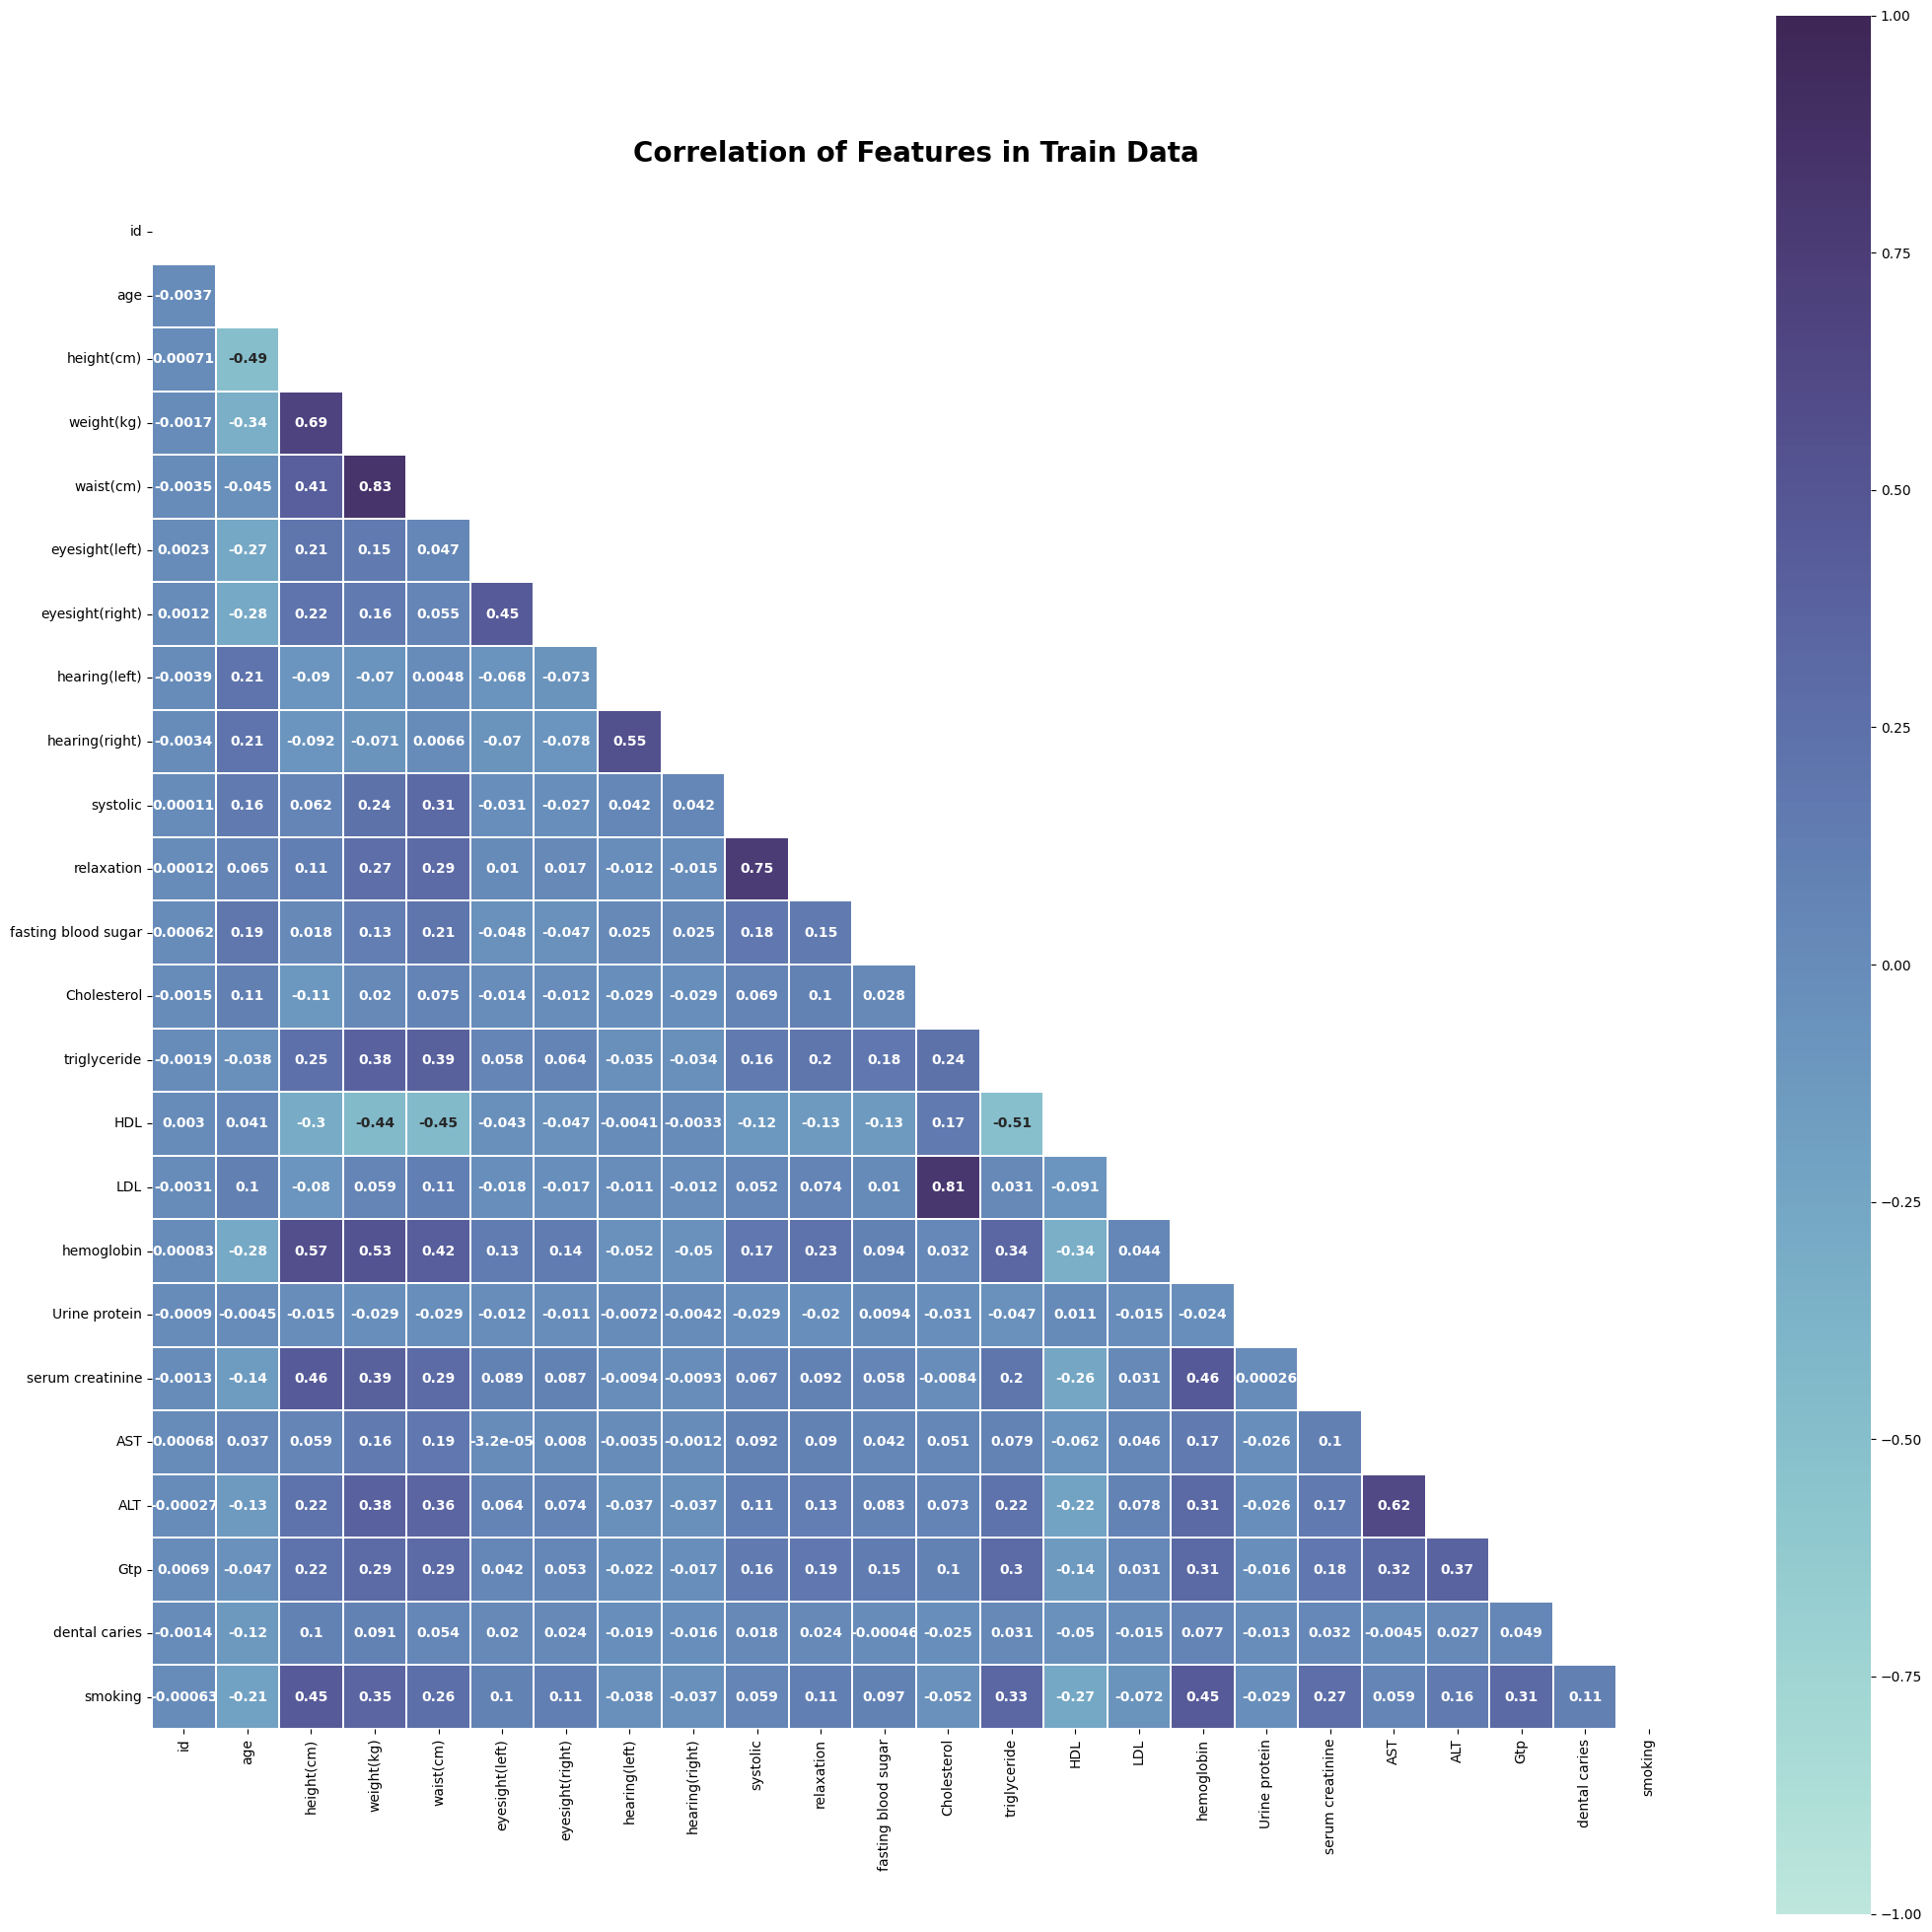

In [16]:
plot_heatmap(train_df, title='Train Data')


<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Feature importances for random forest classifier    </div>

In [17]:
rf_model = final_classifier.estimators[0][1]
rf_model.fit(X, y)

# fetching the feature importances
rf_feature_importances = rf_model.feature_importances_


<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Visualizing feature importances</div>

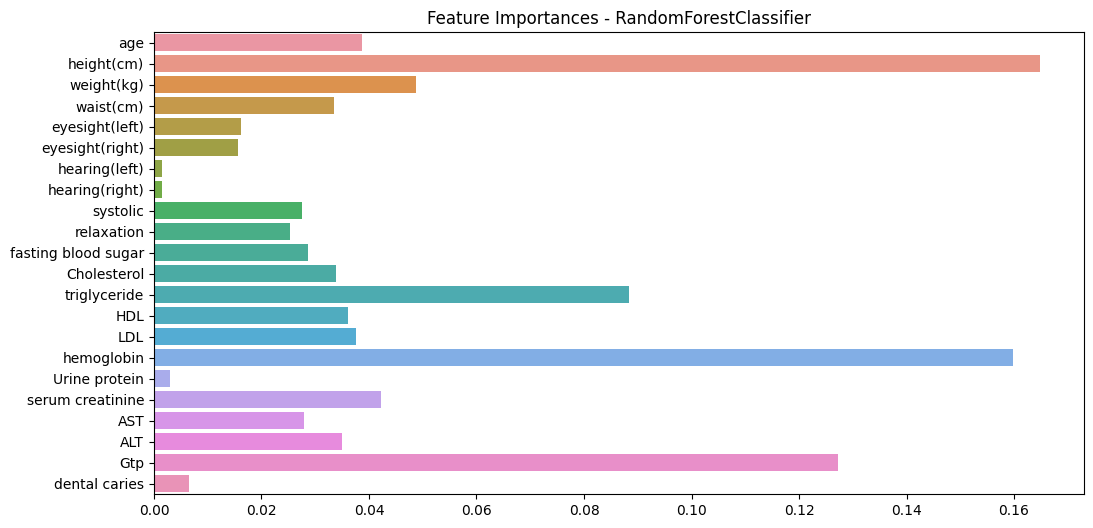

In [18]:
plt.figure(figsize=(12, 6))
sns.barplot(x=rf_feature_importances, y=features)
plt.title('Feature Importances - RandomForestClassifier')
plt.show()

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Making predictions on the test set    </div>

In [19]:
final_classifier.fit(X, y)
X_test = test_df[features]
test_predictions = final_classifier.predict_proba(X_test)[:, 1]


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Generating submission   </div>

In [20]:
submission_df = pd.DataFrame({'id': test_df['id'], 'smoking': test_predictions})


In [21]:
submission_df.to_csv('submission.csv', index=False)

In [22]:
submission_df

,id,smoking
0,159256,0.606335
1,159257,0.193332
2,159258,0.588081
3,159259,0.064682
4,159260,0.566351
...,...,...
106166,265422,0.495929
106167,265423,0.641202
106168,265424,0.433974
106169,265425,0.190606
